### packages

In [6]:
import numpy as np

import pandas as pd

from IPython.display import display

import networkx as nx

import matplotlib.pyplot as plt

import pulp

import copy

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

### utility function 

\begin{equation}
u_{d,o}=\underbrace{\beta_{0,d} \cdot I_{o}}_{\textrm{order type}} +\underbrace{\beta_{1,d} \cdot f_{o}}_{\textrm{order fare}} - \underbrace{\beta_{2,d} \cdot \tau(l^{\textrm{org}}_{o},l_{d})}_{\textrm{pickup time}}  + \underbrace{\beta_{3,d} \cdot V(l^{\textrm{dest}}_{o})}_{\textrm{value of the order's destination}}
\label{eq:utility}
\end{equation}

In [7]:
# 01 numbers of orders and drivers

order_num=20

driver_num=5

# 02 type

type_array=np.ones([order_num,driver_num])

# 03 order price

np.random.seed(0)

price_array=np.zeros([order_num,driver_num])

price=np.random.randint(7,15,order_num)

for i in range(driver_num):
    
    price_array[:,i]=price
    
price_df=pd.DataFrame(price_array,columns=['d'+str(i+1) for i in range(driver_num)])

price_df.index=['o'+str(i+1) for i in range(order_num)]

display(price_df)
    
# 04 pick up distance 

distance_array=np.random.rand(order_num,driver_num)*3

# 05 the spatial value 

spatial_array=np.random.rand(order_num,driver_num)

# 06 utility function

beta_1 = 1

beta_2 = -0.4

beta_3 = 3.2

utility = type_array+beta_1*price_array-beta_2*distance_array+beta_3 *spatial_array

utility_df=pd.DataFrame(utility,columns=['d'+str(i+1) for i in range(driver_num)])

utility_df.index=['o'+str(i+1) for i in range(order_num)]

display(utility_df)

# decline utility

decline=np.random.rand(driver_num)*5+8

decline


,d1,d2,d3,d4,d5
o1,11.0,11.0,11.0,11.0,11.0
o2,14.0,14.0,14.0,14.0,14.0
o3,12.0,12.0,12.0,12.0,12.0
o4,7.0,7.0,7.0,7.0,7.0
o5,10.0,10.0,10.0,10.0,10.0
o6,10.0,10.0,10.0,10.0,10.0
o7,10.0,10.0,10.0,10.0,10.0
o8,14.0,14.0,14.0,14.0,14.0
o9,8.0,8.0,8.0,8.0,8.0
o10,10.0,10.0,10.0,10.0,10.0


,d1,d2,d3,d4,d5
o1,14.380871,15.343182,14.919987,14.062514,14.689396
o2,16.373374,17.843792,17.859217,18.755341,18.260116
o3,16.495156,15.563228,16.613243,15.997404,14.498265
o4,10.708364,8.233442,10.098642,10.738773,9.425843
o5,13.295116,13.301140,11.980897,12.636624,12.846435
o6,13.631955,13.572356,13.830563,14.219228,13.198723
o7,14.300359,12.700636,13.231925,13.926425,14.379941
o8,18.057209,15.573185,18.097056,17.664086,18.632763
o9,10.162471,12.304325,10.706026,11.092244,9.646876
o10,13.907198,14.367151,13.125072,12.862559,11.514645


array([12.95169474,  9.08448492, 11.31539102,  9.31661188,  8.103255  ])

In [77]:
class Joint_Optimization(object):
    
    def __init__(self,utility,decline):
        
        self.utility=utility
        
        self.decline=decline
        
        self.lambda_=.001
        
        self.v = np.ones([utility.shape[0],utility.shape[1]])

    def get_prob(self,o,x):

        p=1

        drivers=x[o,:]

        for d in np.nonzero(drivers)[0]:

            menus=np.nonzero(np.array(x[:,d]))

            p*=(self.utility[menus,d].sum()-utility[o,d]+self.decline[d])/(utility[menus,d].sum()+self.decline[d])

        return 1-p
    
    def get_obj(self,x):

        p=0

        for o in range(x.shape[0]):

            p+=self.get_prob(o,x)

        return p
    
    
    def exists(self,x):
        
        excludes=[e for e in np.argwhere(self.v == 1) if e in np.argwhere(x == 0)]
        
        i=0
        
        while i<len(excludes)-1:

            pair=excludes[i]

            o,d=pair[0],pair[1]

            copy_x=copy.deepcopy(x)

            copy_x[o,d]=1

            if self.get_obj(copy_x)/self.get_obj(x)>=1+self.lambda_:

                x[o][d]=1
                
                excludes=[e for e in np.argwhere(self.v == 1) if e in np.argwhere(x == 0)]
        
                i=0

            else:

                i+=1
        
        return x
        
    def check(self,x):
        
        includes=[e for e in np.argwhere(x == 1)]
        
        redo=False
        
        i=0
        
        while i<len(includes)-1:

            pair=includes[i]

            o,d=pair[0],pair[1]

            copy_x=copy.deepcopy(x)

            copy_x[o,d]=0
            
            
            if self.get_obj(copy_x)/self.get_obj(x)>=1+self.lambda_:
                
                x[o,d]=0

                redo=True
                
                break
                
            else:
                
                i+=1
                
        return x,redo

        
    
    def local_search(self):
        
        # 01 initialization
        
        x = np.zeros([self.utility.shape[0],self.utility.shape[1]])
        
        search={}
        
        for o in range(x.shape[0]):
        
            for d in range(x.shape[1]):
                
                copy_x=copy.deepcopy(x)

                copy_x[o,d]=0
                
                search[(o,d)]=self.get_obj(copy_x)-self.get_obj(x)
                
        best_x=max(search, key=search.get)
            
        o,d=best_x[0],best_x[1]
        
        x[o][d]=1
        
        # 02 while loop
        
        x=self.exists(x)
        
        # 03 check
        
        redo=False
        
        x,redo = self.check(x)
        
        while redo:
            
            print('haha')
            
            x = self.exists(x)
            
            x,redo = self.check(x)
            
            
        return x

                        


In [78]:
joint_opt=Joint_Optimization(utility,decline)

x=joint_opt.local_search()

print('objective function is ',joint_opt.get_obj(x))

x

objective function is  4.355670822799141


array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 0., 0.]])

Allocation binary decisions:


array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 0., 0.]])

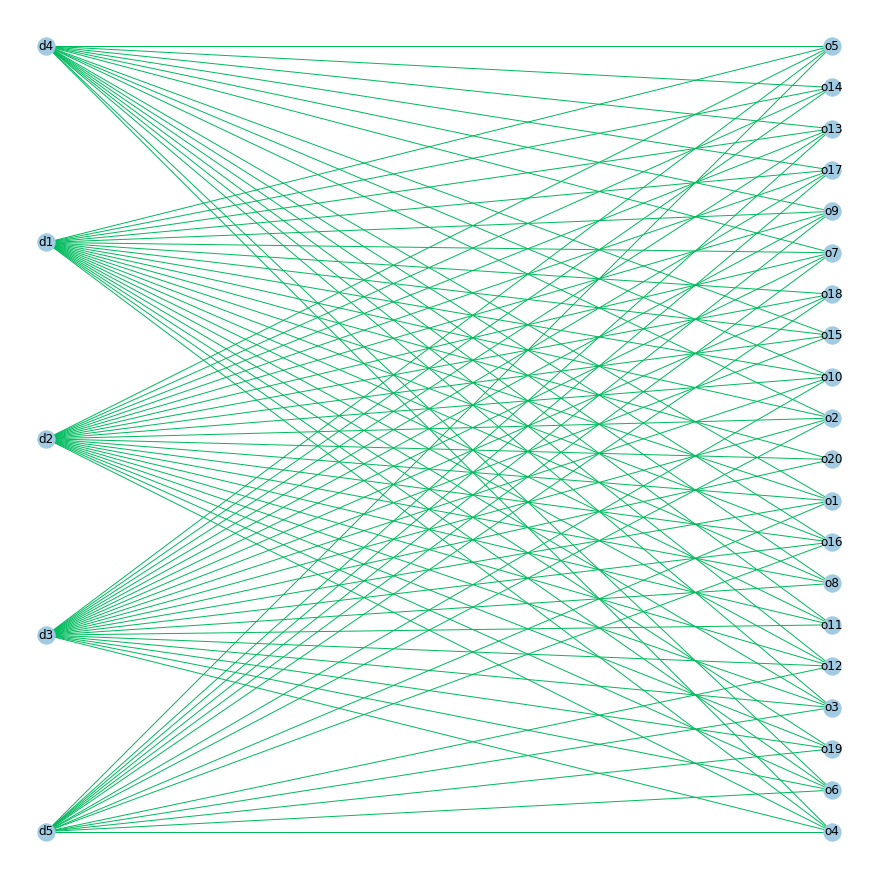

In [79]:
# 05 Allocation

O=np.zeros([order_num,driver_num])
        
for o in range(order_num):

    for d in range(driver_num):

        O[o][d]=np.random.choice([1,0],p=[x[o][d],1-x[o][d]])
        
print('Allocation binary decisions:')

display(O)

# 06 Bipartite graph displaying

B = nx.Graph()

B.add_nodes_from(utility_df.columns, bipartite=0, label='driver')

B.add_nodes_from(utility_df.index, bipartite=1, label='order')

for o in range(order_num):

    for d in range(driver_num):
        
        if O[o][d]==1:

            B.add_edge('d'+str(d+1), 'o'+str(o+1))
    
    
left_or_top = utility_df.columns

pos = nx.bipartite_layout(B, left_or_top)

# Draw the graph

plt.figure(figsize=(12,12)) 

nx.draw(B,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)

plt.show()
